# Imports

In [17]:
import numpy as np
from skimage import color, filters, exposure, morphology, io, measure
import matplotlib.pyplot as plt
import glob
import pytesseract

# Utility Functions

In [18]:
def show_image(image):
    io.imshow(image)
    io.show()

def show_images(images, titles=None):
    fig = plt.figure()
    n = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n + 1)]
    for i in range(n):
        a = fig.add_subplot(1, n, i + 1)
        if images[i].ndim == 2:
            plt.gray()
        plt.imshow(images[i])
        plt.rcParams['axes.titlesize'] = 22
        plt.rcParams['text.color'] = 'w'
        a.set_title(titles[i])
    fig.set_size_inches(np.array(fig.get_size_inches()) * n)
    plt.show()

# Preprocessing

In [19]:
def preprocess(rgb_img, neg_trans_th=50000, debugging=False):
    # Gray scale conversion
    gray_img = color.rgb2gray(rgb_img)    
    # Median filtering
    median_filter_img = filters.median(gray_img, selem=np.ones((3, 3)))
    # Histogram equalization
    equalized_img = exposure.equalize_hist(median_filter_img)
    # Edge detection
    v_edges_img = filters.sobel_v(equalized_img)
    # Binarization
    v_edges_img = v_edges_img > filters.threshold_otsu(v_edges_img)
    if (np.sum(v_edges_img) >= neg_trans_th):
        v_edges_img = 1 - v_edges_img
    if debugging:
        show_images([rgb_img, gray_img, median_filter_img, equalized_img, v_edges_img], ["rgb", "grayscale", "median filter", "histogram equalization", "vertical edges"])
    # Return v_edges_img
    return v_edges_img

# Drawing Functions

In [20]:
# Draw top and bottom rows on a grayscale image
def draw_top_and_bottom(v_edges_img, top_rows, bottom_rows, c):
    new_img = np.copy(v_edges_img)
    new_img[top_rows] = np.ones((1, c))
    new_img[bottom_rows] = np.ones((1, c))
    return new_img

# Draw bounding boxes on a grayscale image
def draw_bounding_boxes(v_edges_img, top_rows, bottom_rows, left_columns, right_columns):
    band_num = top_rows.shape[0]
    new_img = np.copy(v_edges_img)
    for i in range(band_num):
        top_row, bottom_row, left_column, right_column = top_rows[i], bottom_rows[i], left_columns[i], right_columns[i]
        new_img[top_row:bottom_row+1, left_column] = np.ones((bottom_row+1-top_row,))
        new_img[top_row:bottom_row+1, right_column] = np.ones((bottom_row+1-top_row,))
        new_img[top_row, left_column:right_column+1] = np.ones((1, right_column+1-left_column))
        new_img[bottom_row, left_column:right_column+1] = np.ones((1, right_column+1-left_column))
    return new_img

# Draw license plate
def draw_license_plate_box(rgb_img, top, bottom, left, right):
    new_img = np.copy(rgb_img)
    red = np.array([255, 0, 0])
    new_img[top:bottom+1, left, :] = red
    new_img[top:bottom+1, right, :] = red
    new_img[top, left:right+1, :] = red
    new_img[bottom, left:right+1, :] = red
    return new_img

# License Plate Localization

In [21]:
# Locate license plate
def locate_license_plate(rgb_img, v_edges_img, T_min_factor=0.5, variance_factor=0.5, aspect_ratio_lower_th=5, aspect_ratio_upper_th=15, area_lower_th=900, area_upper_th=6600, character_offset=10, debugging=0):
    # Get dimensions
    r = rgb_img.shape[0]
    c = rgb_img.shape[1]
    
    # Calculate sum of edges in each row
    row_sums = np.sum(v_edges_img, axis=1)
    
    # Set T_min and row_mask
    T_min = T_min_factor * np.max(row_sums)
    row_mask = row_sums > T_min
    if debugging > 1:
        plt.title("sum of edges in each row")
        plt.plot(np.arange(r), row_sums)
        plt.show()
    
    # Calculate means of edge pixel positions for rows whose sum of edges > T_min
    row_means = np.zeros((r))
    row_means[row_mask] = np.sum(v_edges_img[row_mask] * np.arange(c) / row_sums.reshape(r, 1)[row_mask], axis=1)
    if debugging > 1:
        plt.title("means of edge pixel positions of each row")
        plt.plot(np.arange(r), row_means)
        plt.show()
    
    # Calculate variances of edge pixel positions for rows whose sum of edges > T_min
    row_variances = np.zeros((r))
    row_variances[row_mask] = 0.5 * np.sqrt(np.sum(np.square(np.arange(c) - row_means.reshape(r, 1))[row_mask], axis=1) / c)
    if debugging > 1:
        plt.title("variances of edge pixel positions of each row")
        plt.plot(np.arange(r), row_variances)
        plt.show()
    
    # Set V_xmax and apply threshold on row_variances
    V_xmax = np.mean(row_variances)
    row_variances[row_variances <= V_xmax] = 0
    if debugging > 1:
        plt.title("variances of edge pixel positions of each row after after thresholding")
        plt.plot(np.arange(r), row_variances)
    
    # Get top and bottom rows for each band
    band_mask = row_variances > V_xmax
    rows = np.where(band_mask[:-1] != band_mask[1:])[0]
    rows = np.insert(np.append(np.array(list(zip(rows[0:], rows[0:] + 1))).reshape(-1, ), r - 1), 0, 0)
    first_band_row = np.where(rows == np.nonzero(band_mask == 1)[0][0])[0][0]
    top_rows = rows[first_band_row::4]
    bottom_rows = rows[first_band_row + 1::4]
    if debugging > 0:
        tb_rows_img = draw_top_and_bottom(v_edges_img, top_rows, bottom_rows, c) 
    
    # Get left and right columns for each band
    band_num = top_rows.shape[0]
    left_columns = np.zeros((band_num,)).astype(np.int32)
    right_columns = np.zeros((band_num,)).astype(np.int32)
    # Loop on all bands
    for i in range(band_num):
        top_row, bottom_row = top_rows[i], bottom_rows[i]
        # Get V_xmax, mu_min, and mu_max
        V_xmax = np.min(row_variances[top_row:bottom_row + 1])
        mu_min = np.min(row_means[top_row:bottom_row + 1])
        mu_max = np.max(row_means[top_row:bottom_row + 1])
        # Set left and right columns
        left_columns[i] = mu_min - V_xmax
        right_columns[i] = mu_max + V_xmax
    # Set out of range columns to first or final column
    left_columns[left_columns<0] = 0
    left_columns[left_columns>(c-1)] = c - 1
    right_columns[right_columns<0] = 0
    right_columns[right_columns>(c-1)] = c - 1
    if debugging > 0:
        bounding_boxes_img = draw_bounding_boxes(v_edges_img, top_rows, bottom_rows, left_columns, right_columns)
    
    # Update left and right columns for each bounding box
    for i in range(band_num):
        top_row, bottom_row, left_column, right_column = top_rows[i], bottom_rows[i], left_columns[i], right_columns[i]
        # Get band
        band = v_edges_img[top_row:bottom_row+1, left_column:right_column+1]
        # Calculate height of edges
        heights = np.sum(band, axis=0)
        # Calculate prominent edges and indices
        prominent_edges = heights > np.mean(heights)
        prominent_indices = (np.where(prominent_edges == 1))[0]
        # Get prominent left and right columns
        if (prominent_indices.shape[0] > 0):
            prominent_left_column, prominent_right_column = prominent_indices[0], prominent_indices[-1]
            # Update left and right columns
            left_columns[i] += prominent_left_column
            right_columns[i] -= (prominent_edges.shape[0] - 1 - prominent_right_column)
    if debugging > 0:
        updated_bounding_boxes_img = draw_bounding_boxes(v_edges_img, top_rows, bottom_rows, left_columns, right_columns)
            
    # Caculate aspect ratio and area for each bounding box
    aspect_ratios = (right_columns - left_columns + 1) / (bottom_rows - top_rows + 1)
    areas = (right_columns - left_columns + 1) * (bottom_rows - top_rows + 1)

    # Remove noisy boxes using thresholds for aspect ratio and area
    aspect_ratio_mask = np.logical_and(aspect_ratios >= aspect_ratio_lower_th, aspect_ratios <= aspect_ratio_upper_th)
    area_mask = np.logical_and(areas > area_lower_th, areas < area_upper_th)
    box_mask = area_mask * aspect_ratio_mask
    
    # Select bounding box for the license plate
    if (np.sum(box_mask) != 0):
        top = max(0, top_rows[box_mask][-1] - int(0.5 * character_offset))
        bottom = min(r - 1, bottom_rows[box_mask][-1] + character_offset)
        left = max(0, left_columns[box_mask][-1] - 2 * character_offset)
        right = min(c - 1, right_columns[box_mask][-1] + 2 * character_offset)
        result_img = draw_license_plate_box(rgb_img, top, bottom, left, right)
        license_found = True
    else:
        top, bottom, left, right = None, None, None, None
        result_img = np.copy(rgb_img)
        license_found = False
        
    # Draw steps of creating bounding boxes
    if debugging > 0:
        show_images([tb_rows_img, bounding_boxes_img, updated_bounding_boxes_img, result_img], ["top and bottom rows of each band", "bounding boxes after second stage", "bounding boxes after third stage", "marked licence plate"])
        
        
    # Retrun coordinates of bounding box
    return (top, bottom, left, right), result_img, license_found

# Test Localization on Dataset

In [ ]:
# Read image paths and text paths
image_paths = glob.glob("./Dataset/*.jpg")
for image_path in image_paths:
    print(image_path)
    # Read rgb_img
    rgb_img = io.imread(image_path)
    # Preprocess image
    v_edges_img = preprocess(rgb_img, debugging=True)
    # Locate the license plate
    box, result_img, license_found = locate_license_plate(rgb_img, v_edges_img, debugging=True)
    # Print result
    show_images([rgb_img, result_img, rgb_img[box[0]:box[1], box[2]:box[3]]], ["rgb", "license plate marked", "license plate"])

# Character Segmentation and Extraction

In [ ]:
def extract_characters(license_plate, neg_trans_th=2700, T_min_factor=0.7, mean_factor=0.4, col_width=4, max_char_width = 17, debugging=1):
    # Get dimensions
    r = license_plate.shape[0]
    c = license_plate.shape[1]
    
    # Convert license plate to grayscale
    gray_license_plate = color.rgb2gray(license_plate)
    # Edge detection
    v_edges_img = filters.sobel_v(gray_license_plate)
    # Binarization
    v_edges_img = v_edges_img > filters.threshold_otsu(v_edges_img)
    if (np.sum(v_edges_img) >= neg_trans_th):
        v_edges_img = np.invert(v_edges_img)
        
    # Calculate sum of edges in each row and apply threshold (histogram mean)
    row_sums = np.sum(v_edges_img, axis=1)
    band_mask = row_sums < T_min_factor * np.mean(row_sums)
    row_sums[band_mask] = 0
    if debugging > 2:
        plt.title("sum of edges in each row after applying threshold")
        plt.plot(np.arange(r), row_sums)
        plt.show()
    
    # Remvove upper and lower parts of license plate
    rows = np.where(band_mask[:-1] != band_mask[1:])[0]
    rows = np.insert(np.append(np.array(list(zip(rows[0:], rows[0:] + 1))).reshape(-1, ), r - 1), 0, 0)
    first_band_row = np.where(rows == np.nonzero(band_mask == 0)[0][0])[0][0]
    top_rows = rows[first_band_row::4]
    bottom_rows = rows[first_band_row + 1::4]
    band_index = np.argmax(bottom_rows - top_rows)
    license_top, license_bottom = int(top_rows[band_index]), int(bottom_rows[band_index])
    gray_license_plate = gray_license_plate[license_top:license_bottom+1, :]
    if debugging > 0:
        cropped_license_plate = license_plate[license_top:license_bottom+1, :]
    
    # Binarization
    binary_license_plate = np.invert(gray_license_plate > filters.threshold_otsu(gray_license_plate))
    
    # Vertical projection histogram
    columns_sums = np.sum(binary_license_plate, axis=0)
    columns_sums = columns_sums > np.mean(columns_sums) * mean_factor
    columns = np.where(columns_sums[:-1] != columns_sums[1:])[0]
    columns = np.insert(np.append(columns, c - 1), 0, 0)
    columns = columns.astype(np.int32)
    columns_mask = (columns[1:] - columns[0:-1]) > col_width
    columns = np.insert((columns[1:])[columns_mask], 0, 0)
    license_plate[:, columns] = [0, 255, 0]
    
    # Character Blob Extraction
    label_image = measure.label(binary_license_plate)
    label_image_rgb = (color.label2rgb(label_image, image=binary_license_plate, bg_label=0)*255).astype("uint8")
    
    extracted_chars = []
    
    for region in measure.regionprops(label_image):
        # Extract Region Properties
        char_top, char_left, char_bottom, char_right = region.bbox
        char_width = char_right - char_left
        char_height = char_bottom - char_top
        red = np.array([255, 0, 0])
        
        # Highlight All Discovered Regions
        label_image_rgb[char_top:char_bottom, char_right-1, :] = red
        label_image_rgb[char_top:char_bottom, char_left, :] = red
        label_image_rgb[char_bottom-1, char_left:char_right, :] = red
        label_image_rgb[char_top, char_left:char_right, :] = red
        
        if char_width < max_char_width and char_height >= license_bottom - license_top - 2:
            if char_width < 8 or (np.sum(binary_license_plate[char_top:char_bottom+1,char_left:char_right+1])/(char_width*char_height) < 0.8):
                # Highlight Selected Regions
                license_plate[(license_top+char_top):(license_top+char_bottom), char_right-1, :] = red
                license_plate[(license_top+char_top):(license_top+char_bottom), char_left, :] = red
                license_plate[license_top+char_bottom-1, char_left:char_right, :] = red
                license_plate[license_top+char_top, char_left:char_right, :] = red

                # Append Selected Regions
                extracted_chars.append((license_top + char_top, license_top + char_bottom, char_left, char_right))
    
    # Sort on Left Boundary
    extracted_chars.sort(key=lambda x: x[2])
    
    # Print result
    if debugging > 0:
        show_images([license_plate, cropped_license_plate, binary_license_plate, label_image_rgb], ["license plate", "cropped license plate", "binary license plate", "segmented license plate"])
        if debugging > 1:
            # Print Individual Characters
            extracted_chars_display = []
            extracted_labels_display = []

            for char in extracted_chars:
                char_top, char_bottom, char_left, char_right = char[0], char[1], char[2], char[3]
                extracted_chars_display.append(binary_license_plate[char_top-license_top:char_bottom+1-license_top,char_left:char_right+1])
                extracted_labels_display.append("w: " + str(char_right-char_left) + " h:" + str(char_bottom-char_top))
                
            show_images(extracted_chars_display,extracted_labels_display)
        show_images([license_plate], ["Extracted Characters (" + str(len(extracted_chars)) + ")"])
    
    return extracted_chars, len(extracted_chars), binary_license_plate, license_top 

# Test Character Segmentation and Extraction on 1 Image

In [ ]:
image_path = "./Dataset/test_01.jpg"
# Read rgb_img
rgb_img = io.imread(image_path)
# Preprocess image
v_edges_img = preprocess(rgb_img, debugging=False)
# Locate the license plate|
box, result_img, license_found = locate_license_plate(rgb_img, v_edges_img, debugging=0)
# Get license plate
license_plate = rgb_img[box[0]:box[1], box[2]:box[3]]
# Extract License Plate Characters
characters = extract_characters(license_plate, debugging = 2)

# Test Character Segmentation and Extraction on Dataset

In [ ]:
# Read image paths and text paths
image_paths = glob.glob("./Dataset/*.jpg")

for image_path in image_paths:
    # Read rgb_img
    rgb_img = io.imread(image_path)
    # Preprocess image
    v_edges_img = preprocess(rgb_img, debugging=False)
    # Locate the license plate
    box, result_img, license_found = locate_license_plate(rgb_img, v_edges_img, debugging=0)
    # Print image path
    print(image_path)
    
    if license_found:
        # Get license plate
        license_plate = rgb_img[box[0]:box[1], box[2]:box[3]]
        # Extract License Plate Characters
        characters = extract_characters(license_plate, debugging = 2)
    else:
        print("No license plate found")

# OCR to Get License Number

In [ ]:
def ocr(license_plate, characters, license_top, padding_amount=8, padding_value=0, use_morphology=True, use_edge_trimming=True, debugging=0):
    
    # Image and Label Arrays for Debug Display
    char_imgs = []
    char_labels =[]
    
    # Function Output String
    full_char_string = ""
    
    # Attempt to Recognize Every Character
    for char in characters:
        # Extract and Pad Character Image
        char_top, char_bottom, char_left, char_right = char[0], char[1], char[2], char[3]
        extracted_char = license_plate[char_top - license_top:char_bottom-license_top+1,char_left:char_right+1]
        padded_char = np.pad(extracted_char, padding_amount, 'constant', constant_values = padding_value)
        
        # Set up morphology sequence (if needed)
        if (use_morphology):
            morphology_seq = []
            morphology_seq.append(morphology.binary_dilation(padded_char, np.ones((2, 2))))
            morphology_seq.append(morphology.binary_dilation(padded_char, np.ones((3, 3))))
            morphology_seq.append(morphology.binary_opening(padded_char, np.ones((2, 2))))
            morphology_seq.append(morphology.binary_closing(padded_char, np.ones((2, 2))))
            morphology_seq.append(morphology.binary_erosion(padded_char, np.ones((2, 2))))
            morphology_seq.append(morphology.binary_opening(padded_char, np.ones((3, 3))))
            morphology_seq.append(morphology.binary_closing(padded_char, np.ones((3, 3))))
            morphology_seq.append(morphology.binary_erosion(padded_char, np.ones((3, 3))))
            morphology_labels = ["Dilation", "Dilation", "Opening", "Closing", "Erosion", "Opening", "Closing", "Erosion"]
        
        # Recognize Character using Tesseract on raw padded image
        char_string = pytesseract.image_to_string(padded_char, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 10')
        
        # Append Character to Results (if found)
        if char_string:
            char_labels.append(char_string)
            char_imgs.append(padded_char)
            full_char_string += char_string[0]
        else:
            # If not found close then try again using morphology sequence until found (if needed)
            if (use_morphology): 
                for i in range(len(morphology_seq)):
                    char_string = pytesseract.image_to_string(morphology_seq[i], config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 10')
                    
                    # Print effect of Morphological operation
                    if debugging > 1: 
                        print("Attempt at " + morphology_labels[i])
                        show_images([padded_char, morphology_seq[i]], ["Before " + morphology_labels[i], "After " + morphology_labels[i]])
                    
                    # If found break sequence
                    if char_string:
                        char_labels.append(char_string)
                        char_imgs.append(morphology_seq[i])
                        full_char_string += char_string[0]
                        break
            
            # If not found, insert empty space
            if not char_string:
                char_labels.append(" ")
                char_imgs.append(padded_char)
                full_char_string += " "
    
    # Use Edge Trimming (Removal of potential missegmented edges at the start and end of the string)
    if (use_edge_trimming):
        if len(full_char_string) > 7:
            # Look for potential Edge (potentially classified as 1 or I) at the start of the string (if count is more than 7)
            while full_char_string[0] == '1' or full_char_string[0] == 'I' or full_char_string[0] == ' ':
                if (debugging > 1):
                    print("Trimming Potential Edge:", full_char_string[0])
                full_char_string = full_char_string[1:]
            # Trim all end chars until count is correct
            while len(full_char_string) > 7:
                if (debugging > 1):
                    print("Trimming Last Char:" ,full_char_string[-1])
                full_char_string = full_char_string[:-1]
            
    # Print Results        
    if debugging > 0:
        show_images(char_imgs, char_labels)
        print("Recognized Plate Number:", full_char_string)
        
    return full_char_string

# Test OCR on 1 Image

In [ ]:
image_path = "./Dataset/test_01.jpg"
# Read rgb_img
rgb_img = io.imread(image_path)
# Preprocess image
v_edges_img = preprocess(rgb_img, debugging=False)
# Locate the license plate
box, result_img, license_found = locate_license_plate(rgb_img, v_edges_img, debugging=False)
# Get license plate
license_plate = rgb_img[box[0]:box[1], box[2]:box[3]]
show_images([rgb_img, result_img, license_plate], ["rgb", "license plate marked", "license plate"])
# Extract License Plate Characters
characters, count, binary_license_plate, license_top = extract_characters(license_plate, debugging = False)
# Call ocr function on license plate
prediction = ocr(binary_license_plate, characters, license_top, padding_amount = 8, debugging = 1)

# Test OCR on Dataset

In [ ]:
# Read image paths and text paths
image_paths = glob.glob("./Dataset/*.jpg")
 
for image_path in image_paths:
    # Print image path
    print(image_path)
    # Read rgb_img
    rgb_img = io.imread(image_path)
    # Preprocess image
    v_edges_img = preprocess(rgb_img, debugging=False)
    # Locate the license plate
    box, result_img, license_found = locate_license_plate(rgb_img, v_edges_img, debugging=False)
    
    # Get truth value from corresponding text file
    f = open(image_path.replace("jpg","txt"), "r")
    truth = f.read()
    
    if license_found:
        # Get license plate
        license_plate = rgb_img[box[0]:box[1], box[2]:box[3]]
        show_images([rgb_img, result_img, license_plate], ["rgb", "license plate marked", "license plate"])
        
        # Extract Characters from License Plate
        characters, count, binary_license_plate, license_top  = extract_characters(license_plate, debugging=False)
        prediction = ocr(binary_license_plate, characters, license_top, use_morphology=True, use_edge_trimming=True, debugging=True)
    else:
        print("No license plate found")
    print("Ground Truth:", truth)

# Application

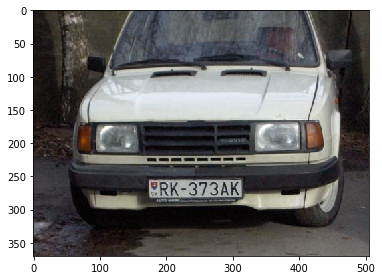

RK373AK
Access Granted


In [40]:
white_list = ["PP587AO", "RK346AL", "RK576AH", "LM633BD", "RK763AS", "3B97236", "RK376AF", "RKO11AM", "RK373AK", "RK891AU"]

# Image path
image_path = "./Dataset/test_36.jpg"

# Gate decision
gate_decision = "Access Denied"

# Read rgb_img
rgb_img = io.imread(image_path)
# Preprocess image
v_edges_img = preprocess(rgb_img, debugging=False)
# Locate the license plate
box, result_img, license_found = locate_license_plate(rgb_img, v_edges_img, debugging=False)

if license_found:
        # Get license plate
        license_plate = rgb_img[box[0]:box[1], box[2]:box[3]]   
        # Extract Characters from License Plate
        characters, count, binary_license_plate, license_top  = extract_characters(license_plate, debugging=False)
        # OCR
        prediction = ocr(binary_license_plate, characters, license_top, use_morphology=True, use_edge_trimming=True, debugging=False)
        # Grant acces for white listed plates
        if prediction in white_list:
            gate_decision = "Access Granted"
            
# Print results
show_image(io.imread(image_path))
print(prediction)
print(gate_decision)